In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time
import argparse
sys.path.append('./tools/')
from forwardmodels import *
from forwardmodels import prosail_3d_L8_alvaro as PROSAIL

from autograd.misc.flatten import flatten_func
import autograd.numpy as np
from autograd import grad, jacobian
from autograd.numpy.linalg import solve
from scipy.stats import  multivariate_normal as mv

from scipy.optimize import fmin_l_bfgs_b

In [2]:
FULL_GAUSSIAN_Q = True

np.random.seed(0)

# Gradient by finite differences

def diff(f, c0, delta = 1e-9):

    c0 = c0.flatten();    
    d = len(c0)
    derivs = None

    for i in range(d):

        step = np.zeros(d)
        step[i] = delta

        xa = c0 - step
        xb = c0 + step

        value = (f(xb) - f(xa)) /(2 * delta) 

        if derivs is None:
            derivs = value
        else:
            derivs = np.vstack((derivs, value))

    return derivs



In [4]:
import pandas as pd
data = pd.read_csv('data4daniel.txt', sep="   ", header=None)
datmat = np.array(data)[:,0:3] * np.array([1,0.1,1]) # conversion from (mg/mm2) to (g/cm2). 
datmat = datmat * np.array([1000,1000,1]) # bring all to similar scale

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


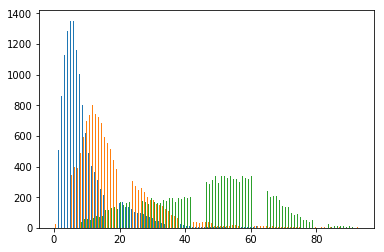

In [5]:
h=plt.hist(datmat,100)

In [6]:
true_prior_mean = np.mean(datmat,0)
true_prior_cov = np.cov(datmat.T)

In [7]:
global D, P
D = 3  # cause dimension
P = 9  # effect dimension

def RTM(c):
    if len(c.shape) == 1:
        return PROSAIL(c.reshape(1,D))
    else:
        return PROSAIL(c)

In [60]:
#############################
### Generate trainingdata ###
#############################

n_data = 2000
C_true = np.dot(np.random.normal(size = (( n_data, D))), np.linalg.cholesky(true_prior_cov).T) + true_prior_mean

E_true = RTM(C_true)

mean_effect = np.mean(E_true, axis = 0)
std_effect = np.std(E_true, axis = 0)

E_true = (E_true - mean_effect) / std_effect

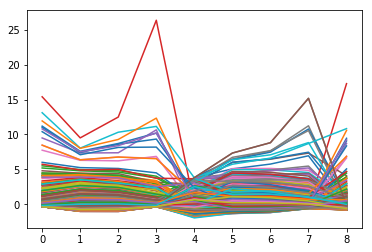

In [61]:
h=plt.plot(E_true.T)

In [62]:
## Define Likelihood and prior

def logprior(params, c):

    m = params['mean_prior']
    L = np.tril(params['chol_cov_prior'], 0) # DHL this is to enforce that the grdient of the upper triangle is zero for autograd
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) # DHL this is to guarantee positive elements in the diagonal
    v = c - m
    upsilon = solve(L, c - m)

    return -1.0 * float(D) / 2 * np.log(2.0  * np.pi) - np.sum(np.log(np.diag(L))) - 0.5 * np.sum(upsilon**2)

def loglikelihood(c, e_orig):

    e = e_orig * std_effect + mean_effect
    log_sigmas = np.ones(len(e)) * -15.0
    sigmas = np.exp(log_sigmas)
    diff = e - RTM(c)

    return np.sum(-0.5 * np.log(2.0 * np.pi) - 0.5 * log_sigmas - 0.5 * diff**2 / sigmas)

### If using a function that cannot be diffed by autograd

def grad_log_likelihood(c, e):
    def log_target_distribution_spec(c):
        return loglikelihood(c, e)
    return diff(log_target_distribution_spec, c)

### If using a function that *can* be diffed by autograd

#def log_target_distribution_autograd(c, e):
#    return loglikelihood(c, e)
#grad_log_likelihood = grad(log_target_distribution_autograd)

# This was used to introduce the prior parameters in the likelihood. It seems it gives wierd results.

def transform_standard_cause_with_prior(c, params):

    m = params['prior']['mean_prior']
    L = params['prior']['chol_cov_prior']
    L = np.tril(params['prior']['chol_cov_prior'], 0)
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) 
    
    return m + np.dot(c, L.T)

In [63]:
##################################
# These are the prior parameters #
##################################

params_prior_ini = {'mean_prior': np.ones(D) * 20, 'chol_cov_prior': np.eye(D) * 4.0 }
params_prior_true = {'mean_prior': true_prior_mean, 'chol_cov_prior': np.linalg.cholesky(true_prior_cov)}

In [64]:
#params_prior_ini['mean_prior'] = np.array([10.25501237 ,17.62609835, 45.21359918])
#fitcov = np.array( [[ 59.4320121  , 49.51342108 , 34.58714439],[ 49.51342108 ,127.10263008 ,  2.35467119], [ 34.58714439  , 2.35467119, 260.56913176]] )
#L = np.linalg.cholesky(fitcov)
#L = L = L - np.diag(np.diag(L)) + np.diag(np.log(np.diag(L))) 
#params_prior_ini['chol_cov_prior'] = L

In [65]:
############################
# Neural Network Functions #
############################

# Relu activation function for non-linearity

def activation(x):    return np.maximum(0, x)

# This function intializes the parameters of a deep neural network

def init_net_params(layer_sizes, scale = 1e-3):

    """Build a (weights, biases) tuples for all layers."""

    network = [(scale * np.random.randn(m, n),   # weight matrix
             scale * np.random.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

    return network

# This computes the output of a deep neuralnetwork with params a list with pairs of weights and biases

def neural_net_predict(params, inputs):

    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix."""

    for W, b in params[:-1]:
        outputs = np.dot(inputs, W) + b  # linear transformation
        inputs = activation(outputs)         # nonlinear transformation

    # Last layer is linear

    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb

    return outputs

# We specify the network layers size

if FULL_GAUSSIAN_Q == True:
    layer_sizes = [ P, 100, 100, int(D + D**2) ]
else:
    layer_sizes = [ P, 100, 100, int(D * 2) ]

init_rec_params = init_net_params(layer_sizes)

params = {'phi': init_rec_params, 'prior': params_prior_ini}

#################################################
# Functions needed to evaluate the VI objective #
#################################################

# Important! One sample and one data point at a time

def sample_from_q_factorizing(params, effect, norm_draw = None):

    prediction = neural_net_predict(params['phi'], effect)

    mean = prediction[ :, 0 : D ]
    variance = np.exp(prediction[ :, D : (2 * D) ])

    if norm_draw is None:
        norm_draw = np.random.normal(size = mean.shape)

    return np.maximum(mean + norm_draw * np.sqrt(variance), 0.1)

#     return mean + norm_draw * np.sqrt(variance)

def sample_from_q_full(params, effect, norm_draw = None):

    prediction = neural_net_predict(params['phi'], effect)

    mean_q = prediction[ :, 0 : D ]
    L_q = np.tril(prediction[ :, D : (D * D + D) ].reshape(D, D), 0) 
    L_q = L_q - np.diag(np.diag(L_q)) + np.diag(np.exp(np.diag(L_q)))
 
    if norm_draw is None:
        norm_draw = np.random.normal(size = mean.shape)

    return np.maximum(mean_q + np.dot(norm_draw, L_q.T), 0.1)

#    return mean_q + np.dot(norm_draw, L_q.T)

def evaluate_expected_log_likelihood(params, effect, norm_draw = None):

    ll = 0.0
    for i in range(effect.shape[ 0 ]):

        if FULL_GAUSSIAN_Q:
            c = sample_from_q_full(params, effect[ i : (i + 1), : ], norm_draw[ i : (i + 1), : ])
        else:
            c = sample_from_q_factorizing(params, effect[ i : (i + 1), : ], norm_draw[ i : (i + 1), : ])
        loggylike = loglikelihood(c[ i, : ], effect[ i, : ])
        #print(c, ' ', loggylike)
        ll += loggylike

    return ll

def evaluate_KL_factorizing(params, effect):

    prediction = neural_net_predict(params['phi'], effect)
    mean_q = prediction[ :, 0 : D ] 
    variance_q = np.exp(prediction[ :, D : (2 * D) ])

    m_prior = params['prior']['mean_prior']
    L = np.tril(params['prior']['chol_cov_prior'], 0)
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) 
    V = np.dot(L, L.T)

    upsilon = solve(L, (m_prior - mean_q).T)
    eta = np.diag(solve(V, np.eye(D)))

    return  np.sum(0.5 * (np.sum(eta * variance_q, axis = 1) + np.sum(upsilon**2, axis = 0) - D \
        + np.log(np.linalg.det(V)) - np.sum(np.log(variance_q), axis = 1)))

def evaluate_KL_full(params, effect):

    KL = 0.0

    m_prior = params['prior']['mean_prior']
    L = np.tril(params['prior']['chol_cov_prior'], 0)
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) 
    V = np.dot(L, L.T)
    log_det_V = np.log(np.linalg.det(V))
    Vinv = solve(V, np.eye(D))

    for i in range(effect.shape[ 0 ]):

        prediction = neural_net_predict(params['phi'], effect[ i : (i + 1), : ])
        mean_q = prediction[ :, 0 : D ] 
        L_q = np.tril(prediction[ :, D : (D * D + D) ].reshape(D, D), 0) 
        L_q = L_q - np.diag(np.diag(L_q)) + np.diag(np.exp(np.diag(L_q))) 
        V_q = np.dot(L_q, L_q.T)
 
        upsilon = solve(L, (m_prior - mean_q).T)

        KL += 0.5 * (np.trace(np.dot(Vinv, V_q)) + np.sum(upsilon**2) - D + log_det_V - np.log(np.linalg.det(V_q)))

    return  KL

def elbo(params, effect, norm_draw, beta = 1.0):

    E_log_likelihood =  evaluate_expected_log_likelihood(params, effect, norm_draw)   
    
    if FULL_GAUSSIAN_Q:
        KL = evaluate_KL_full(params, effect)
    else:
        KL = evaluate_KL_factorizing(params, effect)

    return np.sum(E_log_likelihood) - KL * beta

#################################################################
# Functions needed to evaluate the gradient of the VI objective #
#################################################################

if FULL_GAUSSIAN_Q:
    flat_sample_from_q, unflatten, flat_init_params = flatten_func(sample_from_q_full, params)
else:
    flat_sample_from_q, unflatten, flat_init_params = flatten_func(sample_from_q_factorizing, params)

sample_from_q_jacobian = jacobian(flat_sample_from_q)

def evaluate_expected_log_likelihood_grad(flatparams, effect, norm_draw = None):

    grad = None

    if norm_draw is None:
        norm_draw = np.random.normal(size = ((effect.shape[ 0 ], D)))

    for i in range(effect.shape[ 0 ]):
        c_samples = flat_sample_from_q(flatparams, effect[ i : (i + 1), : ], norm_draw[ i : (i + 1), : ])
        c_jacobian = sample_from_q_jacobian(flatparams, effect[ i : (i + 1), : ], norm_draw[ i : (i + 1), : ])
        grad_log_lik = grad_log_likelihood(c_samples, effect[ i, : ])

        if grad is None:
            grad = np.dot(grad_log_lik.T, c_jacobian)
        else:
            grad += np.dot(grad_log_lik.T, c_jacobian)

    return grad

if FULL_GAUSSIAN_Q:
    flat_evaluate_KL, unflatten, flat_init_params = flatten_func(evaluate_KL_full, params)
else:
    flat_evaluate_KL, unflatten, flat_init_params = flatten_func(evaluate_KL_factorizing, params)

evaluate_KL_grad = grad(flat_evaluate_KL)

def elbo_grad(flatparams, effect, norm_draw, beta = 1.0):

    grad = None

    if norm_draw is None:
        norm_draw = np.random.normal(size = ((effect.shape[ 0 ], D)))

    Elike_grad = evaluate_expected_log_likelihood_grad(flatparams, effect, norm_draw)
    KL_grad = evaluate_KL_grad(flatparams, effect)

    grad = Elike_grad - KL_grad * beta 

    return grad

In [66]:
flat_params = flat_init_params.copy()

In [67]:
#######################################
# Optimization of the ELBO using ADAM #
#######################################

# The batch size is one point. This is expected to speed up training.

n_epochs = 200#100

mt = None
vt = None
t = 0

iters_to_report = 100

beta = 1.0
ll_report = 0.0

t0 = time.time()
VI_saver = {i: {'params':None, 'time':None, 'elbo':None, 'network':None} for i in range(n_epochs) }
for epoch in range(n_epochs):

    ll = 0.0
    
    for i in range(E_true.shape[ 0 ]):

        e = E_true[ i : (i + 1), : ]
        norm_draw = np.random.normal(size = ((1, D))) 
        
        inc_ll = elbo(unflatten(flat_params), e, norm_draw, beta = beta)
        gradient = elbo_grad(flat_params, e, norm_draw, beta = beta).flatten()
        
        ll += inc_ll
        ll_report += inc_ll
        t += 1

        if mt is None or vt is None:
            mt = gradient * 0.0
            vt = gradient * 0.0
        else:
            mt = 0.9 * mt + (1 - 0.9) * gradient
            vt = 0.999 * vt + (1 - 0.999) * gradient**2

        mt_hat = mt / (1 - 0.9**t)
        vt_hat = vt / (1 - 0.999**t)

        #if epoch <= 50:
        #    lrate = 1e-2
        #elif epoch <= 100:
        #    lrate = 5e-3
        #else: 
        #    lrate = 1e-3
        lrate = 1e-3# DHL original
        #lrate = 5e-4
        
        flat_params += lrate * mt_hat / (np.sqrt(vt_hat) + 1e-8)

#        if ((t + 1) % iters_to_report == 0):
#            print("Updates:", t + 1," Avg. ELBO Value:",  ll_report / iters_to_report)
#            ll_report = 0.0

    print("Epoch:",  epoch," Avg. ELBO Value:",  ll / E_true.shape[ 0 ])
    current_params=unflatten(flat_params)
    L = np.tril(current_params['prior']['chol_cov_prior'])
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L)))
    print('fitted mean:\n', current_params['prior']['mean_prior'], '\nfitted covariance: \n', np.dot(L,L.T))
    VI_saver[epoch]['time'] = t0 - time.time()
    VI_saver[epoch]['params'] = unflatten(flat_params)['prior'].copy()
    VI_saver[epoch]['network'] = unflatten(flat_params)['phi'].copy()    
    VI_saver[epoch]['elbo'] = ll / E_true.shape[ 0 ]

#    beta += 1.0 / 200
#    beta = np.minimum(beta, 1.0)
 
###########
# We save #
###########
import pickle
#with open('/home/daniel/projects/sample4Acause/code_vi/pickles/VI_PROSAIL_'+str(n_data), 'wb') as handle:
#    pickle.dump(VI_saver, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Epoch: 0  Avg. ELBO Value: -131774.76568928556
fitted mean:
 [19.71537315 20.13075468 21.12393406] 
fitted covariance: 
 [[2.85367416e+03 2.26693113e+00 3.91599464e+00]
 [2.26693113e+00 2.86477507e+03 7.29061656e+00]
 [3.91599464e+00 7.29061656e+00 3.01634410e+02]]
Epoch: 1  Avg. ELBO Value: -6034.181241907203
fitted mean:
 [19.5080419  21.16840291 22.67611947] 
fitted covariance: 
 [[2849.0201293     2.98123421    7.66964761]
 [   2.98123421 2858.37953278   24.26780658]
 [   7.66964761   24.26780658 1190.8404114 ]]
Epoch: 2  Avg. ELBO Value: -5066.386032004502
fitted mean:
 [19.34028178 22.05191996 23.99162997] 
fitted covariance: 
 [[2836.14746114    5.35767977   13.34214418]
 [   5.35767977 2840.72658654   47.75017267]
 [  13.34214418   47.75017267 2115.57811581]]
Epoch: 3  Avg. ELBO Value: -4082.6586396339503
fitted mean:
 [19.20053168 22.7235529  25.67105021] 
fitted covariance: 
 [[2801.40183371   12.18536402   26.23419836]
 [  12.18536402 2793.01951906   88.28703146]
 [  26.2341

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Epoch: 8  Avg. ELBO Value: nan
fitted mean:
 [17.37344985 21.74014179 34.53458111] 
fitted covariance: 
 [[227.59026121  81.81451361  46.8159624 ]
 [ 81.81451361 191.2242812   98.10776898]
 [ 46.8159624   98.10776898 418.78238866]]
Epoch: 9  Avg. ELBO Value: nan
fitted mean:
 [17.41001677 22.1443543  35.94762315] 
fitted covariance: 
 [[ 68.37603388  51.30845608  30.15095107]
 [ 51.30845608 123.22943181  82.64872506]
 [ 30.15095107  82.64872506 547.79891856]]
Epoch: 10  Avg. ELBO Value: nan
fitted mean:
 [17.45849774 22.50396573 37.2209682 ] 
fitted covariance: 
 [[ 65.4623522   52.05279002  32.9576132 ]
 [ 52.05279002 125.89202278  84.63481915]
 [ 32.9576132   84.63481915 384.37110176]]
Epoch: 11  Avg. ELBO Value: nan
fitted mean:
 [17.49478856 22.7409422  38.41171053] 
fitted covariance: 
 [[ 66.89582789  53.4092422   36.33773024]
 [ 53.4092422  132.21814645  85.98543855]
 [ 36.33773024  85.98543855 378.32258019]]
Epoch: 12  Avg. ELBO Value: nan
fitted mean:
 [17.52160808 22.94884082

Epoch: 43  Avg. ELBO Value: -570.1573295085738
fitted mean:
 [19.21988158 26.91112105 51.03254194] 
fitted covariance: 
 [[ 69.43532199  57.50670899  36.58616702]
 [ 57.50670899 131.48575024  16.08368824]
 [ 36.58616702  16.08368824 244.05643991]]
Epoch: 44  Avg. ELBO Value: -666.4982081427473
fitted mean:
 [19.23218387 26.95739737 51.13191522] 
fitted covariance: 
 [[ 70.46423746  57.66540284  36.09140475]
 [ 57.66540284 135.07863502  14.85413427]
 [ 36.09140475  14.85413427 236.71489987]]
Epoch: 45  Avg. ELBO Value: -610.8455449234673
fitted mean:
 [19.27362905 26.97025634 51.16230354] 
fitted covariance: 
 [[ 67.872792    56.67340912  35.23700139]
 [ 56.67340912 130.01193436  15.91311944]
 [ 35.23700139  15.91311944 244.04922323]]
Epoch: 46  Avg. ELBO Value: -862.4217942023969
fitted mean:
 [19.30901774 26.98697013 51.21137758] 
fitted covariance: 
 [[ 68.48515516  56.93021883  35.30641044]
 [ 56.93021883 132.58980697  15.84701022]
 [ 35.30641044  15.84701022 252.40756767]]
Epoch: 4

Epoch: 77  Avg. ELBO Value: -685.713271600485
fitted mean:
 [19.55475035 27.35941739 51.65227738] 
fitted covariance: 
 [[ 69.75693099  57.33497478  32.4605965 ]
 [ 57.33497478 135.1380379   11.1066871 ]
 [ 32.4605965   11.1066871  230.89300302]]
Epoch: 78  Avg. ELBO Value: -354.72125068351954
fitted mean:
 [19.57829697 27.34779877 51.59666403] 
fitted covariance: 
 [[ 68.95740897  56.89141686  31.93086251]
 [ 56.89141686 135.28256637  10.87113193]
 [ 31.93086251  10.87113193 247.95818276]]
Epoch: 79  Avg. ELBO Value: nan
fitted mean:
 [19.56380478 27.36199703 51.60842204] 
fitted covariance: 
 [[ 67.35986512  56.37292438  31.54273801]
 [ 56.37292438 135.48038165  10.43236984]
 [ 31.54273801  10.43236984 237.59679408]]
Epoch: 80  Avg. ELBO Value: -712.3888295794111
fitted mean:
 [19.57108108 27.35854606 51.54604977] 
fitted covariance: 
 [[ 68.33468234  56.81760549  32.34291263]
 [ 56.81760549 137.36826572  11.13412201]
 [ 32.34291263  11.13412201 233.81781788]]
Epoch: 81  Avg. ELBO Va

Epoch: 111  Avg. ELBO Value: nan
fitted mean:
 [19.53717344 27.38687801 51.584181  ] 
fitted covariance: 
 [[ 67.8026827   56.45287141  34.17797391]
 [ 56.45287141 136.55903359  12.58662822]
 [ 34.17797391  12.58662822 235.28501646]]
Epoch: 112  Avg. ELBO Value: nan
fitted mean:
 [19.54862242 27.38029496 51.5664573 ] 
fitted covariance: 
 [[ 67.91909856  56.47928504  34.64050409]
 [ 56.47928504 135.07677441  12.61047249]
 [ 34.64050409  12.61047249 244.73339577]]


KeyboardInterrupt: 

# MCEM

In [70]:
import sys
import argparse
sys.path.append('./tools/')
#from forwardmodels import *
#from forwardmodels import prosail_4d_L8 as PROSAIL
from hmc import HMC
from scipy.optimize import fmin_l_bfgs_b

In [71]:
n_data = 2000
C_true = np.dot(np.random.normal(size = (( n_data, D))), np.linalg.cholesky(true_prior_cov).T) + true_prior_mean
E_true = RTM(C_true)

In [72]:
np.random.seed(0)

def diff(f, c0, delta = 1e-9):

    c0 = c0.flatten();    
    d = len(c0)
    derivs = None

    for i in range(d):

        step = np.zeros(d)
        step[i] = delta

        xa = c0 - step
        xb = c0 + step

        value = (f(xb) - f(xa)) /(2 * delta) 

        if derivs is None:
            derivs = value
        else:
            derivs = np.vstack((derivs, value))

    return derivs

###########
########### The RTM model and the training data has already been generated
###########
E_true = RTM(C_true) # because the code below runs without normalization


## Define Likelihood and prior

def logprior(params, c):

    m = params['mean_prior']
    L = np.tril(params['chol_cov_prior'], 0) # DHL this is to enforce that the grdient of the upper triangle is zero for autograd
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) # DHL this is to guarantee positive elements in the diagonal
    v = c - m
    upsilon = solve(L, c - m)

    return -1.0 * float(D) / 2 * np.log(2.0  * np.pi) - np.sum(np.log(np.diag(L))) - 0.5 * np.sum(upsilon**2)

def loglikelihood(params, c, e):

#    log_sigmas = params['log_sigmas']
    log_sigmas = np.ones(len(e)) * -15.0
    sigmas = np.exp(log_sigmas)
    diff = e - RTM(np.atleast_2d(c))

    return np.sum(-0.5 * np.log(2.0 * np.pi) - 0.5 * log_sigmas - 0.5 * diff**2 / sigmas)

params_ini = {'mean_prior': np.ones(D) * 20, 'chol_cov_prior': np.eye(D) * 4.0  }
params_true = {'mean_prior': true_prior_mean, 'chol_cov_prior': np.linalg.cholesky(true_prior_cov)}
current_params = params_ini

e = E_true[0,:]
c = C_true[0,:]

# We generate the functions needed for HMC

def log_target_distribution(c, e):
    return logprior(current_params, c) + loglikelihood(current_params, c, e)

def grad_log_target_distribution(c, e):

    def log_target_distribution_spec(c):
        return log_target_distribution(c, e)

    return diff(log_target_distribution_spec, c)

# Finds the MAP solution

def find_C(e, current_params):
    
    def obj(c):
        return -1.0 * log_target_distribution(c, e)

    def gr_obj(c):
        return -1.0 * grad_log_target_distribution(c, e)

    mean = current_params['mean_prior']
    L = current_params['chol_cov_prior']
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) 
    covariance = np.dot(L, L.T)

    ini = (np.dot(np.random.normal(size = (( 1, D))), \
        np.linalg.cholesky(covariance).T) + mean).flatten()

    result = fmin_l_bfgs_b(obj, ini, gr_obj)

    best_value = result[ 1 ]
    best_point = result[ 0 ]

    for k in range(10):

        ini = (np.dot(np.random.normal(size = (( 1, D))), \
            np.linalg.cholesky(covariance).T) + mean).flatten()

        result = fmin_l_bfgs_b(obj, ini, gr_obj)

        if result[ 1 ] < best_value:
            best_point = result[ 0 ]
            best_value = result[ 1 ]
    
    return best_point

In [73]:
n_epochs = 10#50

mt = None
vt = None
t = 0

samples = np.zeros((n_data, D))

from joblib import Parallel, delayed
import multiprocessing

t0 = time.time()
MCEM_saver = {i: {'params':None, 'time':None, 'Q':None} for i in range(n_epochs) }
for epoch in range(n_epochs):

    E_true = E_true[ np.random.permutation(E_true.shape[ 0 ]), : ]

    def sample_from_posterior_for_data_instance(i):
        e = E_true[ i , : ]
        c = find_C(e, current_params)

        # We run the chain for 20 steps to generate one independent sample

        def log_target_distribution_HMC(c):
            return log_target_distribution(c, e)

        def grad_log_target_distribution_HMC(c):
            return grad_log_target_distribution(c, e)

        hmc = HMC(c, log_target_distribution_HMC, grad_log_target_distribution_HMC)
        hmc.run_chain(20, 1e-4, 20)

        sys.stdout.write('.')
        sys.stdout.flush()

        return hmc.samples[-1,:].copy()

    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(sample_from_posterior_for_data_instance)(i) for i in range(n_data))

    samples = np.asarray(results)

    def Q(params, c, e):
        return logprior(params, c) + loglikelihood(params, c, e)

    value_Q = 0.0

    for i in range(n_data):
        value_Q += Q(current_params, samples[ i, : ], E_true[ i, : ])

    current_params['mean_prior'] = np.mean(samples, 0)
    cov = np.cov(samples.T) * (n_data - 1) / (n_data)
    L = np.linalg.cholesky(cov)
    L = L - np.diag(np.diag(L)) + np.diag(np.log(np.diag(L))) 
    current_params['chol_cov_prior'] = L

    print("\nEpoch:",  epoch, "\n")
    print("\nAvg. Value Q:",  value_Q, "\n")
    print(current_params)
    print("Estimated Mean and covariance matrix")
    print(current_params['mean_prior'])
    L = current_params['chol_cov_prior']
    L = L - np.diag(np.diag(L)) + np.diag(np.exp(np.diag(L))) 
    print(np.dot(L, L.T))
    
    MCEM_saver[epoch]['time'] = t0 - time.time()
    MCEM_saver[epoch]['params'] = current_params.copy()  
    MCEM_saver[epoch]['Q'] = value_Q


###########
## Save ###
###########
import pickle
#with open('/home/daniel/projects/sample4Acause/code_vi/pickles/MCEM_PROSAIL_'+str(n_data), 'wb') as handle:
#    pickle.dump(MCEM_saver, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch: 0 


Avg. Value Q: nan 

{'mean_prior': array([20.29499287, 27.69630208, 52.21829577]), 'chol_cov_prior': array([[ 2.26416469,  0.        ,  0.        ],
       [ 5.84162123,  2.54287796,  0.        ],
       [ 7.23319757, -2.22580963,  3.01291827]])}
Estimated Mean and covariance matrix
[20.29499287 27.69630208 52.21829577]
[[ 92.60372612  56.21440584  69.60566044]
 [ 56.21440584 195.82666392  13.94972649]
 [ 69.60566044  13.94972649 471.26118791]]

Epoch: 1 


Avg. Value Q: 95270.06861518715 

{'mean_prior': array([20.29140798, 28.01267633, 51.81376144]), 'chol_cov_prior': array([[ 2.10432643,  0.        ,  0.        ],
       [ 6.81546705,  2.2778486 ,  0.        ],
       [ 4.17664483, -3.25556365,  2.79141794]])}
Estimated Mean and covariance matrix
[20.29140798 28.01267633 51.81376144]
[[ 67.26586156  55.89757625  34.25507318]
 [ 55.89757625 141.62367881  -3.2944179 ]
 [ 34.25507318  -3.2944179  293.8674383 ]]

Epoch: 2 


Avg. Value Q: 86889.32108537428 

{'mean_prior': 